## Quick tutorial for FLORAH

This notebook is a quick tutorial for FLORAH. We use a recurrent neural network + normalizing flows to learn the distributions of MAHs and generate new ones. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

import florah
from florah import utils
from florah.models import rnn_model

%matplotlib inline

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2023-08-30 14:55:43.446557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 14:55:45.326295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read the dataset
As a first step, we read an example dataset that contains the MAHs of 10000 halos from the VSDMPL box of the MultiDark simulations. Each MAH is subsampled to 5 - 20 timesteps. The log virial mass $\log M_{\rm vir}$ and the DM concentration $c_{\rm vir} \equiv R_{\rm vir}/r_{s}$ are stored as node features.

In [2]:
# read in the dataset
# note that we will not use the tree features in this tutorial
node_features, tree_features, headers  = utils.io.read_dataset('example_data.h5')

# the node features is a dictionary, each key stores a list of numpy arrays
# each numpy array is the node features of a tree 
# in this case the nodes are the halo at each time step
x = node_features['x']   # halo mass and concentration
t = node_features['t']   # scale factor

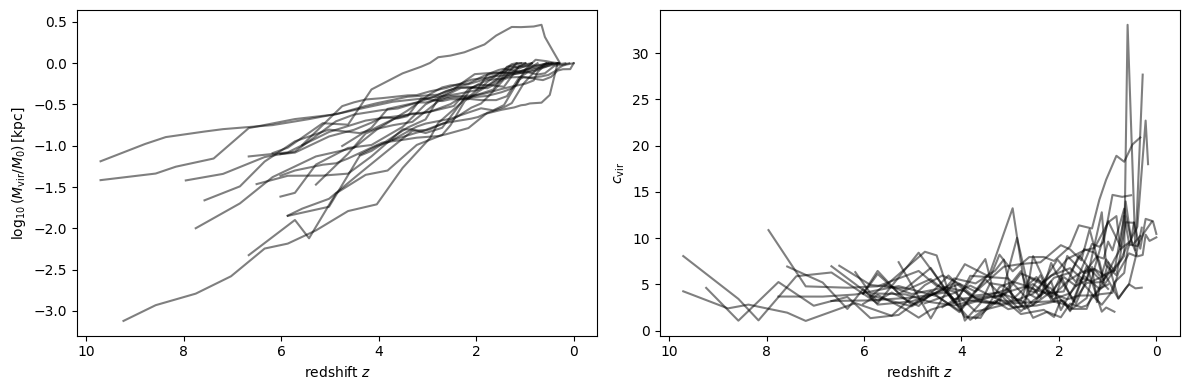

In [3]:
# plot a few examples
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# plot the MAH and CAH of first 10 trees at each redshift
for i in range(20):
    z = 1 / t[i] - 1  # redshift
    axes[0].plot(z, x[i][:, 0] - x[i][0, 0], c='k', alpha=0.5)
    axes[1].plot(z, x[i][:, 1], c='k', alpha=0.5)

axes[0].set_ylabel(r'$\log_{10}(M_\mathrm{vir} / M_0) \, [\mathrm{kpc}]$')
axes[1].set_ylabel(r'$c_\mathrm{vir}$')
axes[0].set_xlabel(r'redshift $z$')
axes[1].set_xlabel(r'redshift $z$')
axes[0].invert_xaxis()
fig.tight_layout()

## Training

We will now train a recurrent neural network consists of 2 Gated Recurrent Unit (GRU) layers and 4 Masked Autoregressive Flow (MAF) layers.
The GRU layers are used to encode the MAHs at each time step into a latent space, and the MAF layers will take in the latent space and sample the next time step. 

In [4]:
# define hyperparameters
# model architecture
model_hparams = dict(
    in_channels=2,   # number of input channels, in this case it is the halo mass and concentration
    out_channels=2,   # number of output channels, in this case it is also the halo mass and concentration
    num_layers=4,
    hidden_features=128,
    num_layers_flows=4,
    hidden_features_flows=128,
    num_blocks=2,
    rnn_name="GRU",
)
# optimizer
optimizer_hparams = dict(
    optimizer=dict(
        optimizer="AdamW",
        lr=5e-4,
        betas=(0.9, 0.98)
    ),
    scheduler=dict(
        scheduler="ReduceLROnPlateau",
        patience=10
    )
)
# time series preprocessing transformation
transform_hparams = dict(
    nx=2, 
    ny=2,
    sub_dim=1
)

# Now we can create the model. The model is a Pytorch Lightning module, which 
# will store the hyperparameters and the optimizer.
model = rnn_model.rnn_generator.DataModule(
    model_hparams, transform_hparams, optimizer_hparams
)

In [5]:
# preprocess the data and create DataLoader
# new node features: x, y, t, seq_len, mask
# x: halo mass and concentration at the current time step (normalized)
# y: accreted mass and concentration at next time step (normalized)
# t: normalized time
# seq_len: length of each time series
# mask: mask for padding
preprocessed_node_features = model.transform(node_features, fit=True)

dataset = torch.utils.data.TensorDataset(*preprocessed_node_features)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True, num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

In [6]:
# Create a Pytorch lightning trainer. This will handle the training loop and
# checkpointing.
trainer  = pl.Trainer(
    default_root_dir="example_run",
    accelerator="auto",
    devices=1,
    max_epochs=100,
    logger=pl.loggers.CSVLogger("example_run", name="example_run"),
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            filename="{epoch}-{val_loss:.4f}", save_weights_only=False,
            mode="min", monitor="val_loss"),
        pl.callbacks.LearningRateMonitor("epoch"),
    ],
    enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# Start training
trainer.fit(
    model=model, train_dataloaders=data_loader,
    val_dataloaders=None)

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | RecurrentMAF | 552 K 
1 | transform | Preprocess   | 0     
-------------------------------------------
552 K     Trainable params
0         Non-trainable params
552 K     Total params
2.210     Total estimated model params size (MB)
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s, loss=4.6, v_num=1]          

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:381: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s, loss=-1.16, v_num=1]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 15.25it/s, loss=-1.16, v_num=1]


## Example sampling

In [15]:
# Now we can sample the trees from the trained model.
n_trees = 100

# We first need to define the roots of the trees, which are the initial
# mass and concentration of the halos.
# for this tutorial we will just reuse the roots of the training trees
roots = np.stack([tree[0] for tree in node_features['x']])
roots = roots[:n_trees]

# We also need to define the redshifts at which we want to sample the trees.
redshifts = np.genfromtxt('vsmdpl_snapshots.txt', delimiter=',', unpack=True)[2]
redshifts = redshifts[redshifts < 10]
scale_factors = 1 / (1 + redshifts)
scale_factors = scale_factors[::4]
scale_factors = np.repeat(scale_factors[None, :], n_trees, axis=0)
scale_factors = scale_factors[..., np.newaxis]

# sample the trees
sampled_trees = utils.sampling.sample_trees(model, roots, scale_factors)

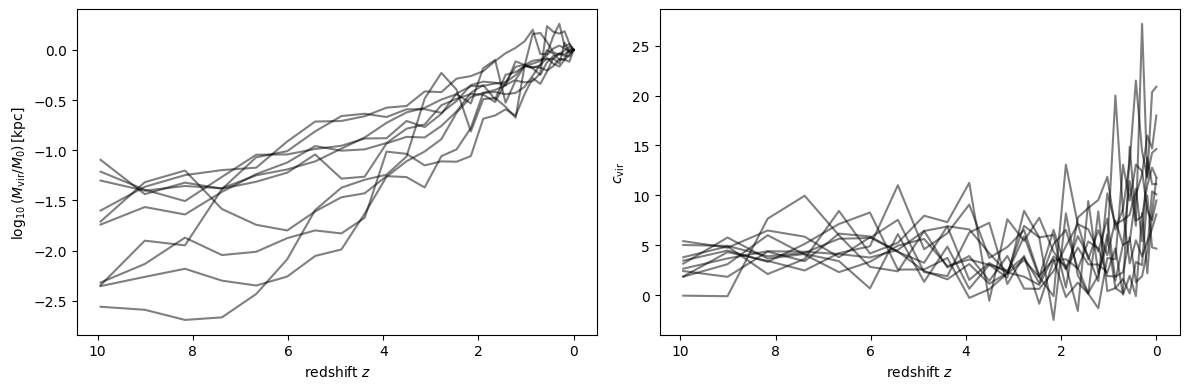

In [16]:
# plot a few examples
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# plot the MAH and CAH of first 10 trees at each redshift
for i in range(10):
    z = 1 / scale_factors[i] - 1  # redshift
    axes[0].plot(z, sampled_trees[i][:, 0] - sampled_trees[i][0, 0], c='k', alpha=0.5)
    axes[1].plot(z, sampled_trees[i][:, 1], c='k', alpha=0.5)


axes[0].set_ylabel(r'$\log_{10}(M_\mathrm{vir} / M_0) \, [\mathrm{kpc}]$')
axes[1].set_ylabel(r'$c_\mathrm{vir}$')
axes[0].set_xlabel(r'redshift $z$')
axes[1].set_xlabel(r'redshift $z$')
axes[0].invert_xaxis()

fig.tight_layout()

This is not very good yet, but we can see that the generated MAHs are roughly similar to the training set.
Generative models require a lot of training data, so we will need to train on a larger dataset (much more than these 10000 MAHs) to get better results.